<a href="https://colab.research.google.com/github/PYMaksim/DecisionTreesOnTitanic/blob/main/Titanic_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset
titanic = sns.load_dataset("titanic")
titanic.head(10)  # First lines

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [73]:
# Сheck for missing data
missing_values_table = pd.concat([
    titanic.isnull().sum(),
    titanic.isnull().mean()
], axis=1)
missing_values_table.rename(columns={0: 'Omissions', 1: '% Omissions'}, inplace=True)
display(missing_values_table)
# Of course, 19 % is not that much for decision trees and it may not affect the model, but nevertheless we apply the KNN method of imputation.
# 77 % (desk) even for decisive trees can be significant, we remove.
# 'embarked' and 'embark_town' significantly.

,Omissions,% Omissions
survived,0,0.000000
pclass,0,0.000000
sex,0,0.000000
age,177,0.198653
sibsp,0,0.000000
parch,0,0.000000
fare,0,0.000000
embarked,2,0.002245
class,0,0.000000
who,0,0.000000


In [74]:
# KNN method of imputation
from sklearn.impute import SimpleImputer, KNNImputer
imputer_knn = KNNImputer(n_neighbors=5)
titanic['age'] = imputer_knn.fit_transform(titanic[['age']]).ravel()

In [75]:
# Deleting a column 'deck'
titanic = titanic.drop(['deck'], axis=1)

In [76]:
# look at the result
missing_values_table = pd.concat([
    titanic.isnull().sum(),
    titanic.isnull().mean()
], axis=1)
missing_values_table.rename(columns={0: 'Omissions', 1: '% Omissions'}, inplace=True)
display(missing_values_table)
# Wonderful !

,Omissions,% Omissions
survived,0,0.000000
pclass,0,0.000000
sex,0,0.000000
age,0,0.000000
sibsp,0,0.000000
parch,0,0.000000
fare,0,0.000000
embarked,2,0.002245
class,0,0.000000
who,0,0.000000


In [77]:
# check the balance of classes in the target feature 'survived'
print(titanic['survived'].value_counts())
# The model may not work correctly because the classes are unbalanced, with an approximate 60% excess of examples of those who did not survive.
# The model may tend to favour the class with more examples.

survived
0    549
1    342
Name: count, dtype: int64


In [78]:
# Downsampling. Data balancing method.
from sklearn.utils import resample

# Highlighting examples of each class
df_majority = titanic[titanic['survived'] == 0]
df_minority = titanic[titanic['survived'] == 1]

# Undersampling the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # disable duplication
                                   n_samples=len(df_minority), # equal number of examples
                                   random_state=42)  # fix a random state for reproducibility

# Merge undersampled data
titanic_balanced = pd.concat([df_majority_downsampled, df_minority])

# Mixing the data
titanic_balanced = titanic_balanced.sample(frac=1, random_state=42)

# Checking out the new class balance
print(titanic_balanced['survived'].value_counts())

survived
1    342
0    342
Name: count, dtype: int64


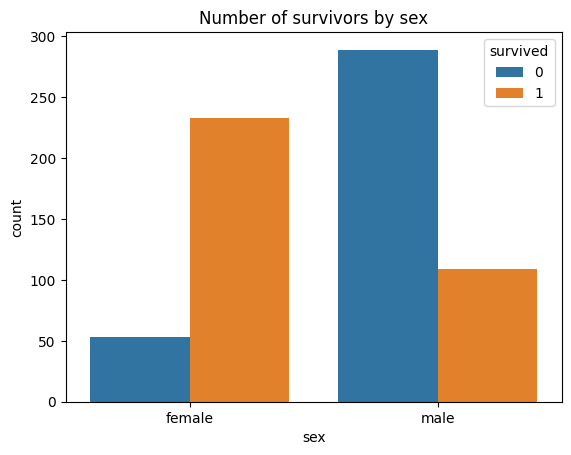

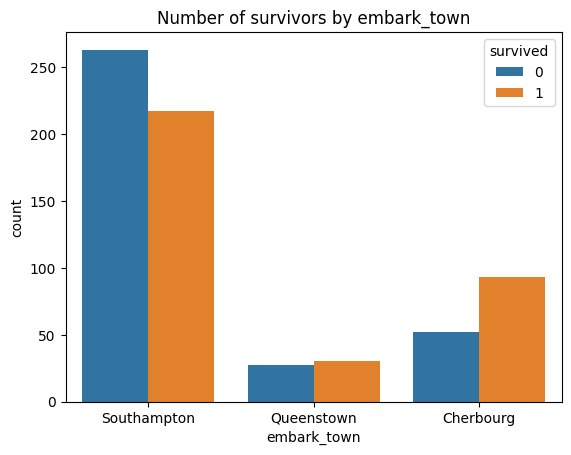

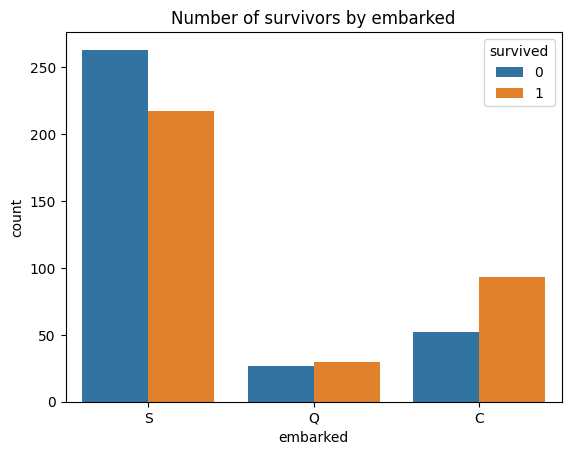

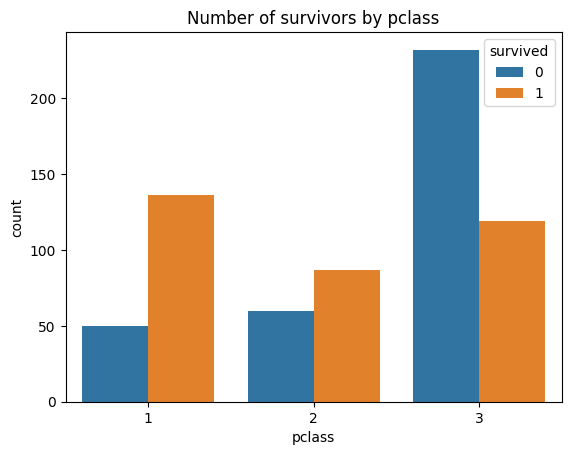

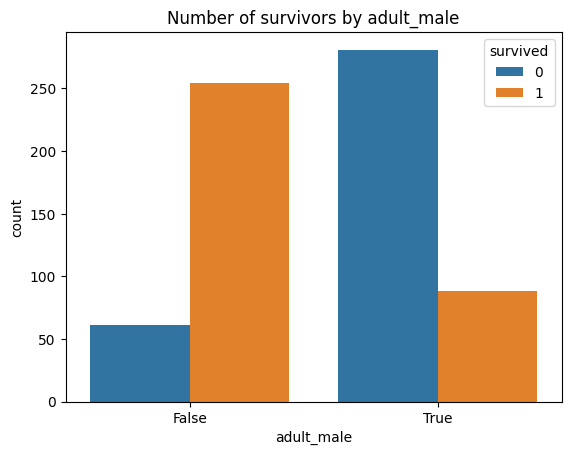

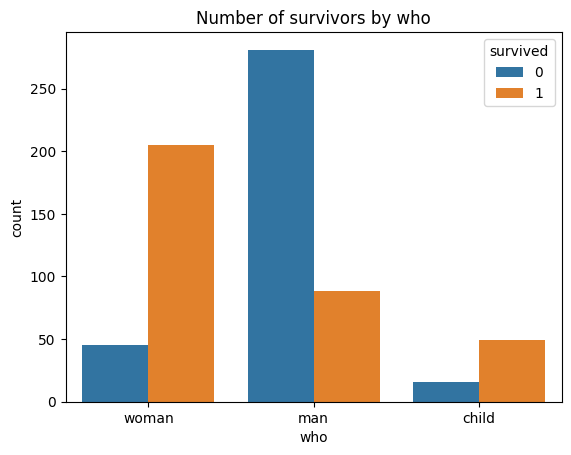

In [79]:
# Analyse categorical attributes
for col in ['sex','embark_town','embarked', 'pclass', 'adult_male', 'who']:
    sns.countplot(x=col, hue='survived', data= titanic_balanced)
    plt.title(f'Number of survivors by {col}')
    plt.show()
# Since the 'embarked','embark_town' trait does not have a significant effect on survival,
# it can be excluded from the dataset to simplify the model and reduce the risk of overtraining.

In [80]:
# Delete 'embarked'
titanic_balanced = titanic_balanced.drop('embarked', axis=1)

In [81]:
# Delete 'embarked_town'
titanic_balanced = titanic_balanced.drop('embark_town', axis=1)

In [82]:
titanic_balanced.head()

,survived,pclass,sex,age,sibsp,parch,fare,class,who,adult_male,alive,alone
394,1,3,female,24.000000,0,2,16.7000,Third,woman,False,yes,False
674,0,2,male,29.699118,0,0,0.0000,Second,man,True,no,True
402,0,3,female,21.000000,1,0,9.8250,Third,woman,False,no,False
145,0,2,male,19.000000,1,1,36.7500,Second,man,True,no,False
856,1,1,female,45.000000,1,1,164.8667,First,woman,False,yes,False


In [83]:
# import the necessary libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [84]:
# convert category data into numeric data
from sklearn.preprocessing import LabelEncoder

for col in ['sex', 'class', 'who', 'alive', 'adult_male','alone' ]:
    le = LabelEncoder()
    titanic_balanced[col] = le.fit_transform(titanic_balanced[col])

In [85]:
titanic_balanced.head()
# Well done ! Now all the data is numerical

,survived,pclass,sex,age,sibsp,parch,fare,class,who,adult_male,alive,alone
394,1,3,0,24.000000,0,2,16.7000,2,2,0,1,0
674,0,2,1,29.699118,0,0,0.0000,1,1,1,0,1
402,0,3,0,21.000000,1,0,9.8250,2,2,0,0,0
145,0,2,1,19.000000,1,1,36.7500,1,1,1,0,0
856,1,1,0,45.000000,1,1,164.8667,0,2,0,1,0


In [86]:
# prepare and divide the data
X = titanic_balanced.drop('survived', axis=1)  # All columns except target variable ‘survived’
y = titanic_balanced['survived']               # Target variable

# Divide the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# train the model
tree_clf = DecisionTreeClassifier(criterion='gini', # The criterion for measuring node cleanliness (default ‘gini’; alternatives: ‘entropy’)
    splitter='best',         # Strategy for selecting the best partition (default ‘best’; alternatives: ‘random’)
    max_depth=5,             # Maximum tree depth (limits tree growth to prevent overfitting)
    min_samples_split=2,     # Minimum number of samples required to split a node (default 2)
    min_samples_leaf=1,      # Minimum number of samples required for a sheet to exist (default 1)
    min_weight_fraction_leaf=0.0,  # Minimum leaf weight (as a fraction of total weight)
    max_features=None,       # Number of features to consider when searching for the best partitioning (None - all features)
    random_state=42,         # Initial state of the random number generator for reproducibility of results
    max_leaf_nodes=None,     # Maximum number of end nodes (leaves); None - unlimited
    min_impurity_decrease=0.0,  # Minimum reduction of the heterogeneity criterion for continued partitioning
    ccp_alpha=0.0            # Alpha parameter for tree post-processing (complexity reduction)
)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [88]:
# Class predictions based on the test set. Model accuracy calculations
y_pred = tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


In [68]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Using Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We perform cross-validation and obtain a list of accuracy estimates
scores = cross_val_score(tree_clf, X, y, cv=cv, scoring='accuracy')

# Output the mean results and the standard deviation
mean_accuracy = scores.mean()
std_deviation = scores.std()

print(f'Mean Accuracy: {mean_accuracy:.2f} +/- {std_deviation:.2f}')
# Perfect accuracy ! The average deviation is 0
# The model correctly categorises all the examples in each section of the data

Mean Accuracy: 1.00 +/- 0.00


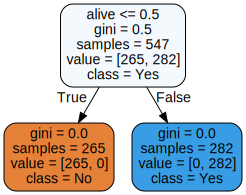

In [66]:
# Visualise the graphs . To understand the logic behind the decisions
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(tree_clf, out_file="titanic_tree.dot",
                feature_names=X.columns, class_names=['No', 'Yes'], filled=True, rounded=True)

with open("titanic_tree.dot") as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

In [89]:
# important features
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': tree_clf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances.head())  # Let's summarise the main features

  feature  importance
9   alive         1.0
0  pclass         0.0
1     sex         0.0
2     age         0.0
3   sibsp         0.0


In [60]:
# Adjusting model hyperparameters using the Grid Search technique
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4] # the minimum number of samples required for the existence of the sheet
}

grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(f'Best params: {best_params}, Best accuracy: {best_accuracy:.4f}')

Best params: {'max_depth': 3, 'min_samples_leaf': 1}, Best accuracy: 1.0000


In [61]:
# Alternatives. Logical regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg:.2f}")

Logistic Regression Accuracy: 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
# Alternatives. Random forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print(f"Random Forest Accuracy: {accuracy_rfc:.2f}")

Random Forest Accuracy: 1.00
